# Lab8. CIFAR-100 Classification with ResNet

Lab8에서는 assignment4-CIFAR-10 classification with CNN코드의 model architecture 부분을 수정하여 ResNet architecture를 통해 CIFAR-100 classification을 해보겠습니다. 

[ResNet implementation with Pytorch](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)를 참고하였습니다.

아래 명령을 통하여 Colab 서버 컴퓨터 내에 결과들을 저장할 results 폴더를 생성합니다. 
이미 생성되어 있는 경우 `mkdir: cannot create directory 'results': File exists`와 같은 에러가 발생하나, 폴더가 이미 존재한다면 상관없으니 넘어가 줍시다.

In [0]:
!mkdir results3

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

# Data Preparation

기존 CIFAR-10 데이터 저장 코드에서 10을 100으로 바꿔주기만 하면 CIFAR-100 dataset을 사용할 수 있습니다.

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# Model Architecture

[ResNet implementation with Pytorch](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)를 참고하여 ResNet architecture를 구현해봅시다.

### conv3x3 and conv1x1 functions
자주 사용하게 될 1x1과 3x3 filter convolutional layer는 꼭 필요한 parameter인 `in_planes`, `out_planes`, `stride`만을 받아 convolutional layer module를 return해주는 함수를 만들어 사용합시다.

In [0]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, 
                     bias=False)

### BasicBlock Module
2개의 3x3 convolution layer와 skip connection으로 구성된 `BasicBlock` module을 구현해봅시다.

[BasicBlock Module Image](https://imgur.com/a/M9gZjWc)

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride) # 이미지 절반으로 줄이려면 
        self.bn1 = nn.BatchNorm2d(planes)                   #stride=2
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes) # stride 명시 안하면 기본값 1
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### Bottleneck Module
50개 이상의 layer를 가진 ResNet architecture에서 computational efficiency를 증가시키기 위해 3x3 convolution layer 앞뒤로 1x1 convolution layer를 추가한 `Bottleneck` module을 구현해 봅시다.

[Bottleneck Module Image](https://imgur.com/a/HrpmJbU)

In [0]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion) # bottleneck는 
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)     #depth 4배증가
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ResNet Module

적절한 Block type과 layer 수, 그리고 최종적으로 분류할 class 갯수를 받아 ResNet architecture를 구현해봅시다.

In [0]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Train, Validate, Test and Experiment

In [0]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [0]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [0]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [0]:
def experiment(partition, args):
  
    net = ResNet(Bottleneck, args.layers)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, 
        train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment Result

In [0]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results3/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results3'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Visualizatin Utility

In [0]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')
    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?
    
def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

## New Section

In [0]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp4_testing_optim&lr"

args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.l2 = 0.00001
args.epoch = 10
args.layers=[3, 8, 36,3]

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'optim'
name_var2 = 'lr'
list_var1 = ["SGD", "Adam"]
list_var2 = [0.01]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result=experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(epoch=10, exp_name='exp4_testing_optim&lr', l2=1e-05, layers=[3, 8, 36, 3], lr=0.01, optim='SGD', test_batch_size=1024, train_batch_size=512)
Epoch 0, Acc(train/val): 1.43/1.10, Loss(train/val) 5.06/394.36. Took 21.30 sec
Epoch 1, Acc(train/val): 3.50/4.93, Loss(train/val) 4.41/4.23. Took 21.47 sec
Epoch 2, Acc(train/val): 6.70/8.01, Loss(train/val) 4.08/4.00. Took 21.65 sec
Epoch 3, Acc(train/val): 8.92/9.18, Loss(train/val) 3.92/3.90. Took 22.26 sec
Epoch 4, Acc(train/val): 11.52/11.61, Loss(train/val) 3.78/3.79. Took 22.63 sec
Epoch 5, Acc(train/val): 13.34/12.52, Loss(train/val) 3.66/3.72. Took 22.79 sec
Epoch 6, Acc(train/val): 14.96/14.02, Loss(train/val) 3.55/3.64. Took 23.13 sec
Epoch 7, Acc(train/val): 16.81/15.08, Loss(train/val) 3.46/3.60. Took 22.85 sec
Epoch 8, Acc(train/val): 18.90/16.53, Loss(train/val) 3.36/3.48. Took 22.82 sec
Epoch 9, Acc(train/val): 20.26/16.62, Loss(train/val) 3.26/3.46. Took 22.92 sec
Namespace(epoch=10, exp_name='exp4_testing_optim&lr', 

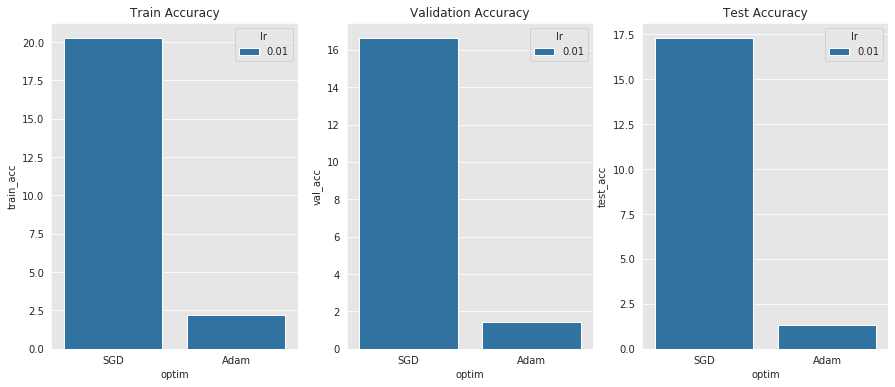

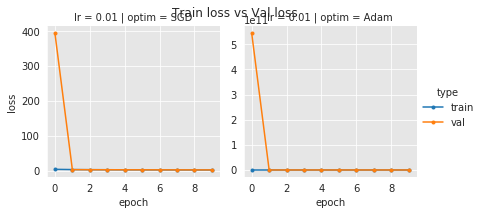

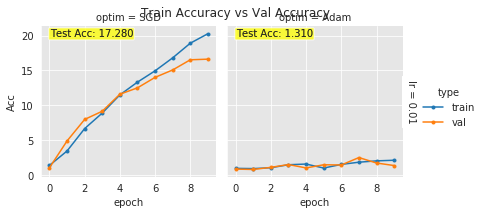

In [0]:
var1 = 'optim'
var2 = 'lr'
df = load_exp_result('exp4')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.